In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np 
import imageio

from torch_geometric.data import Batch, Data

from pytranskit.optrans.continuous.cdt import CDT

from layers.ect import EctLayer
from layers.config import EctConfig

from datasets.mnist import MnistDataModule 
from datasets.config import MnistDataModuleConfig

import matplotlib.pyplot as plt
import numpy as np

import matplotlib.animation as animation

# plt.rcParams["animation.html"] = "jshtml"
from kaolin.metrics.pointcloud import chamfer_distance



In [19]:
NUM_PTS = 100
DEVICE = 'cuda:0'
NUM_THETAS = 64




dataset = MnistDataModule(MnistDataModuleConfig())
for batch in dataset.train_dataloader():
    break





In [20]:
batch[0].x.shape

torch.Size([100, 2])

In [21]:
V = torch.vstack(
    [
        torch.sin(torch.linspace(0, 2 * torch.pi, NUM_THETAS,device=DEVICE)),
        torch.cos(torch.linspace(0, 2 * torch.pi, NUM_THETAS,device=DEVICE)),
        # torch.zeros_like(torch.linspace(0, 2 * torch.pi, NUM_THETAS,device=DEVICE))
    ]
)

CONFIG = EctConfig(device=DEVICE,bump_steps=NUM_THETAS,num_thetas=NUM_THETAS,normalized=True)
ectlayer = EctLayer(config = CONFIG,V=V)


In [22]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = EctLayer(config = CONFIG,V=V)
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(NUM_THETAS**2,4*1024), # (N, 784) -> (N, 128)
            nn.Tanh(),
            nn.Linear(4*1024,4*1024), # (N, 784) -> (N, 128)
            nn.Tanh(),
            nn.Linear(4*1024, 2*NUM_PTS) 
        )

    def forward(self, batch):
        _batch = batch.clone()
        _batch.ect = self.layer(_batch)
        _batch.x = self.encoder(_batch.ect).view(-1,2) 
        _batch.batch = torch.arange(batch.batch.max().item()+1,device=DEVICE).repeat_interleave(NUM_PTS)
        decoded = self.layer(_batch) 
        return decoded, _batch

In [23]:
model = Autoencoder().to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [24]:
for batch in dataset.train_dataloader(): 
    break




In [25]:
print(batch.batch.max())
batch.x.shape


tensor(63)


torch.Size([6400, 2])

In [26]:
# Point to training loop video
num_epochs = 100
outputs = []

for epoch in range(num_epochs):
    for batch in dataset.train_dataloader():
        batch = batch.to(DEVICE)
        recon, _batch = model(batch)
        batch_ect = ectlayer(batch) 
        loss = criterion(recon, batch_ect) + chamfer_distance(
            F.pad(batch.x.view(-1,100,2),[0,1]),
            F.pad(_batch.x.view(-1,100,2),[0,1])
        ).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.6f}')
    # outputs.append((epoch, batch, recon, _batch))

Epoch:1, Loss:0.012457
Epoch:2, Loss:0.011524
Epoch:3, Loss:0.011178
Epoch:4, Loss:0.010119
Epoch:5, Loss:0.009173
Epoch:6, Loss:0.008870
Epoch:7, Loss:0.009366
Epoch:8, Loss:0.009599
Epoch:9, Loss:0.008600
Epoch:10, Loss:0.008517
Epoch:11, Loss:0.008360
Epoch:12, Loss:0.007781
Epoch:13, Loss:0.007879
Epoch:14, Loss:0.007895
Epoch:15, Loss:0.007463
Epoch:16, Loss:0.007014
Epoch:17, Loss:0.007859
Epoch:18, Loss:0.007697


KeyboardInterrupt: 

In [27]:
torch.save(model,"./trained_models/model.pt")


In [29]:
for test_batch in dataset.test_dataloader():
    break

recon_batch, internal_batch = model(test_batch.to(DEVICE))




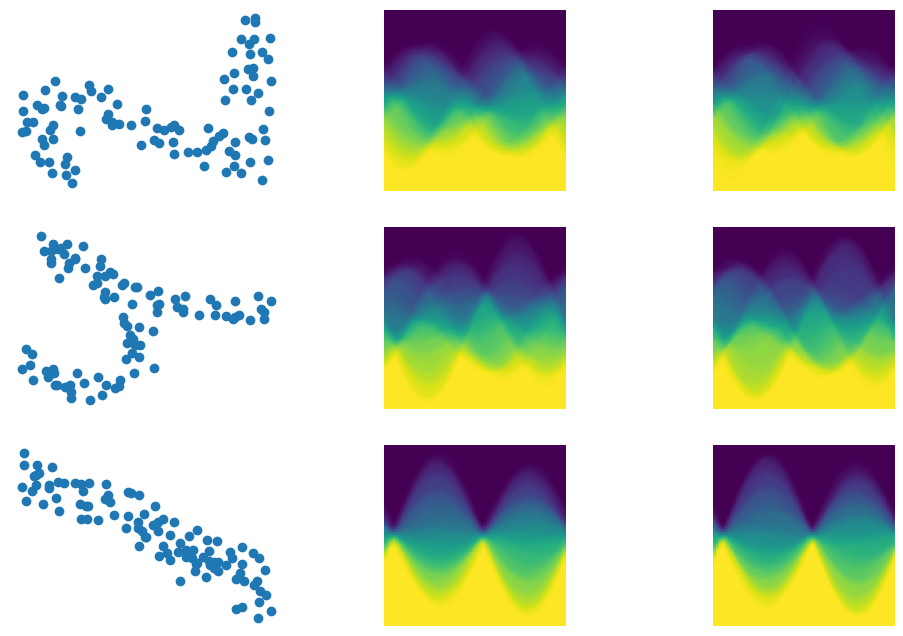

In [30]:
indices = [1,6,2]


fig, axes = plt.subplots(len(indices),3,figsize=(12,8))

for idx,batch_idx in enumerate(indices):
    pred = internal_batch.x[NUM_PTS*batch_idx:NUM_PTS*batch_idx+NUM_PTS].cpu().detach().numpy()
    points = test_batch[batch_idx].x.cpu().detach().numpy()

    ax = axes[idx,0]
    ax.axis("off")
    # ax.scatter(points[:,0],points[:,1])
    ax.scatter(pred[:,0],pred[:,1])

    ax = axes[idx,1]
    ax.axis("off")
    ax.imshow(recon_batch[batch_idx].cpu().squeeze().detach().numpy())

    ax = axes[idx,2]
    ax.axis("off")
    ax.imshow(internal_batch.ect[batch_idx].cpu().squeeze().detach().numpy())


In [31]:

def ect_interp(ect_start, ect_end):
    N=NUM_THETAS
    x0 = np.linspace(0, 1, N)
    I0= np.ones(x0.size)
    x=np.linspace(0, 2, N)
    num_thetas = NUM_THETAS
    ect = np.zeros((num_thetas,num_thetas))
    I1 = abs(ect_start) + 1e-7
    I2 = abs(ect_end) + 1e-7

    I1 = I1/I1.sum(axis=0)
    I2 = I2/I2.sum(axis=0)
    
    taus = np.linspace(0,1,100)
    cdt1 = CDT()
    inter = []

    for tau in taus: 
        for idx in range(num_thetas):
            # Compute the forward transform
            I1_hat, I1_hat_old, xtilde = cdt1.forward(x0, I0, x, I1[:,idx], rm_edge=False)
            I2_hat, I2_hat_old, xtilde = cdt1.forward(x0, I0, x, I2[:,idx], rm_edge=False)


            I_hat = ( tau ) * I1_hat + ( 1 - tau ) * I2_hat  
            I_recon = cdt1.inverse(I_hat, I0, x)

            ect[:,idx] = I_recon
            
        inter.append(ect)
        ect = np.zeros((num_thetas,num_thetas))
    return np.stack(inter)

In [32]:

derlayer = EctLayer(config = EctConfig(num_thetas=NUM_THETAS,bump_steps=NUM_THETAS,device=DEVICE,ect_type="points_derivative"))
derlayer.v = V




# test_batch = Batch.from_data_list([Data(x=torch.tensor([[.4,0]],dtype=torch.float32)), Data(x=torch.tensor([[0,0.4]],dtype=torch.float32))]).to(DEVICE)

ect_batch_der = derlayer(test_batch)
ect_batch_linear = ectlayer(test_batch)

ect_start_der = ect_batch_der[0].cpu().squeeze().detach()
ect_end_der = ect_batch_der[25].cpu().squeeze().detach() 

ect_start_linear = ect_batch_linear[0].cpu().squeeze().detach()
ect_end_linear = ect_batch_linear[25].cpu().squeeze().detach() 


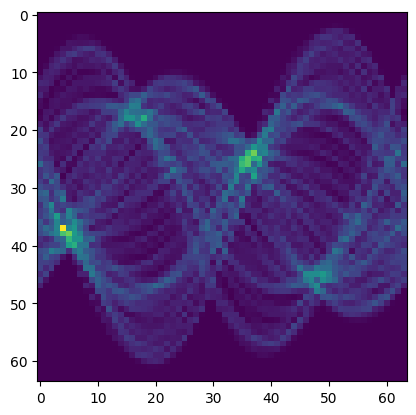

In [33]:
plt.imshow(ect_batch_der[0].squeeze().cpu().numpy())

In [40]:
interp_ect = torch.tensor(ect_interp(ect_start_der.numpy(),ect_end_der.numpy()),dtype=torch.float32,device=DEVICE).cumsum(dim=1)
lin = torch.linspace(0,1,100).view(-1,1,1)
interp_linear = lin * ect_start_linear.unsqueeze(0) + (1-lin) * ect_end_linear.unsqueeze(0)

print(interp_linear.max())

tensor(1.)


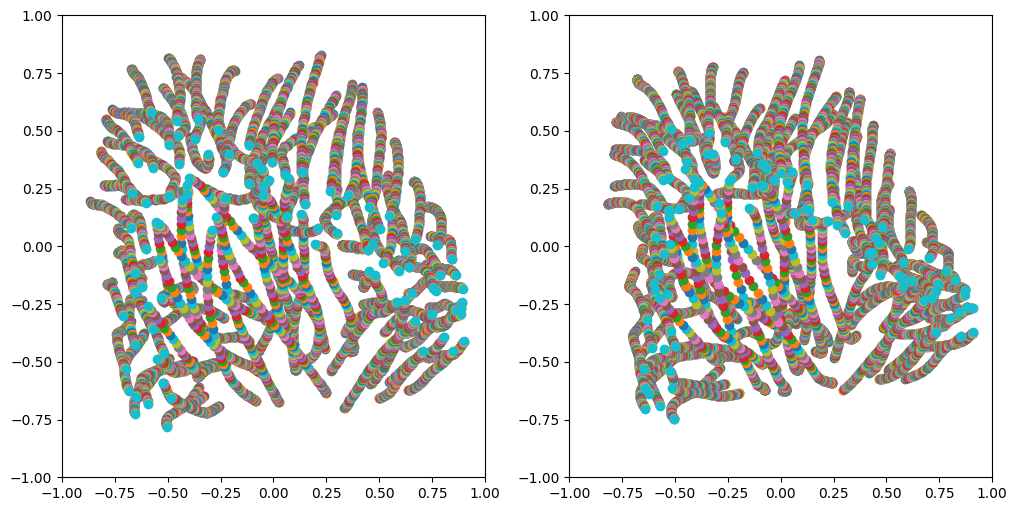

In [35]:
# batch = Batch.from_data_list([Data(x=el.squeeze()) for el in interp])

fig,axes = plt.subplots(1,2,figsize=(12,6))

axes[0].set_xlim([-1,1])
axes[0].set_ylim([-1,1])


axes[1].set_xlim([-1,1])
axes[1].set_ylim([-1,1])


for idx in range(100):
    pts = model.encoder(interp_ect[idx].view(1,NUM_THETAS,NUM_THETAS)).view(-1,2).cpu().detach().numpy()
    axes[0].scatter(pts[:100,0],pts[:100,1])
    pts_linear = model.encoder(interp_linear[idx].view(1,NUM_THETAS,NUM_THETAS).cuda()).view(-1,2).cpu().detach().numpy()
    axes[1].scatter(pts_linear[:100,0],pts_linear[:100,1])

plt.show()


In [37]:
# Pass batch through the encoder. 
pts_interp_ect = model.encoder(interp_ect.unsqueeze(1)).view(-1,2).detach().cpu().numpy()
pts_interp_linear = model.encoder(interp_linear.unsqueeze(1).cuda()).view(-1,2).detach().cpu().numpy()

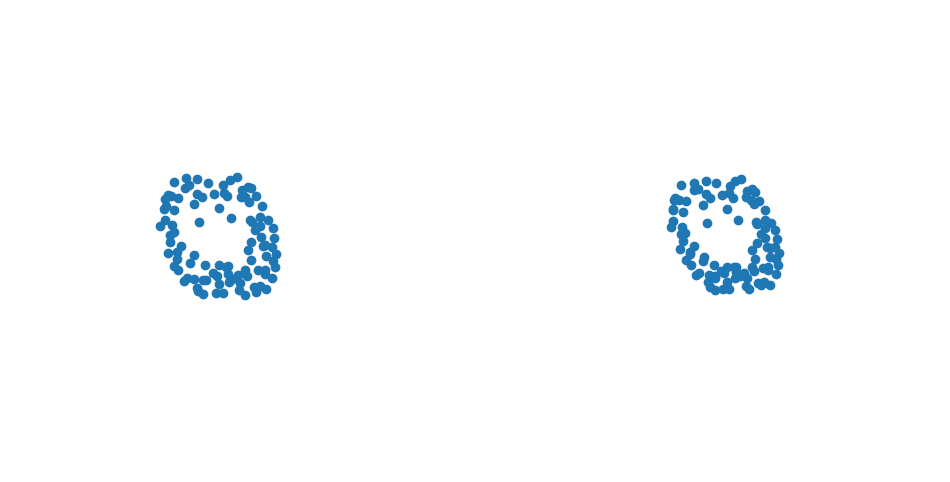

In [38]:
pts = pts_interp_ect[:NUM_PTS]
pts_linear = pts_interp_linear[:NUM_PTS]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

ax0 = axes[0]
ax0.axis("off")
ax0.set_xlim([-3,3])
ax0.set_ylim([-3,3])
scat = ax0.scatter(pts[:,0],pts[:,1])

ax0 = axes[1]
ax0.axis("off")
ax0.set_xlim([-3,3])
ax0.set_ylim([-3,3])
scat2 = ax0.scatter(pts_linear[:,0],pts_linear[:,1])


def update(idx):
    pts = pts_interp_ect[NUM_PTS*idx:NUM_PTS*idx+NUM_PTS]
    pts_linear = pts_interp_linear[NUM_PTS*idx:NUM_PTS*idx+NUM_PTS]
    scat.set_offsets(pts)
    scat2.set_offsets(pts_linear)


ani = animation.FuncAnimation(fig=fig, func=update, frames=100, interval=30)

from IPython.display import HTML
HTML(ani.to_jshtml())
